In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [2]:
import numpy as np
import cv2

In [3]:
os.mkdir("../train_images")
os.mkdir("../test_images")

In [4]:
for x in os.listdir("../input/aptos2019-blindness-detection/train_images/"):

    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/"+x,0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    cv2.imwrite("../train_images/"+x,cl1)
    
for x in os.listdir("../input/aptos2019-blindness-detection/test_images/"):

    img = cv2.imread("../input/aptos2019-blindness-detection/test_images/"+x,0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    cv2.imwrite("../test_images/"+x,cl1)

# for x in os.listdir("../input/aptos2019-blindness-detection/train_images/"):
#     img = cv2.imread("../input/aptos2019-blindness-detection/train_images/"+x,0)
#     equ = cv2.equalizeHist(img)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     cl1 = clahe.apply(equ)
#     cv2.imwrite("../train_images/"+x,cl1)
    
# for x in os.listdir("../input/aptos2019-blindness-detection/test_images/"):
#     img = cv2.imread("../input/aptos2019-blindness-detection/test_images/"+x,0)
#     equ = cv2.equalizeHist(img)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     cl1 = clahe.apply(equ)
#     cv2.imwrite("../test_images/"+x,cl1)

In [5]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy, error_rate

In [6]:
test_df = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
test_img = ImageList.from_df(test_df, path="..", folder='/test_images',suffix='.png')

In [7]:
train_df = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)

In [8]:
np.random.seed(5)
data = (ImageList.from_df(train_df,path="..",folder="/train_images",suffix='.png')
        .split_by_rand_pct()
        .label_from_df(cols='diagnosis')
        .add_test(test_img)
        .transform(tfms,size = 224)
        .databunch(bs=32)    
        .normalize(imagenet_stats)
       )

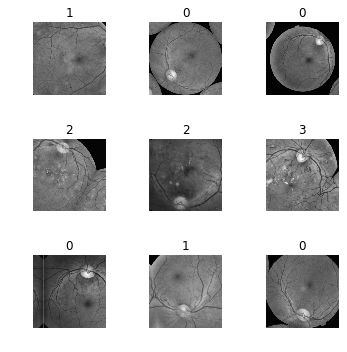

In [9]:
data.show_batch(rows=3,figsize = (5,5))

In [10]:
data.valid_ds.classes

[0, 1, 2, 3, 4]

In [11]:
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp ../input/resnet50/resnet50.pth /tmp/.cache/torch/checkpoints/resnet50.pth

In [12]:
!mv  /tmp/.cache/torch/checkpoints/resnet50.pth /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

In [13]:
model = cnn_learner(data,models.resnet50, metrics = [accuracy,error_rate],callback_fns=ShowGraph)

In [14]:
model.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [15]:
model.model_dir = '../kaggle/working/models/'

In [16]:
# model.lr_find()
# model.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.866010,0.819389,0.719945,0.280055,05:47
1,0.748466,0.670537,0.747268,0.252732,05:44
2,0.673970,0.501172,0.797814,0.202186,05:41
3,0.582005,0.446870,0.825137,0.174863,05:39
4,0.542325,0.427223,0.841530,0.158470,05:42


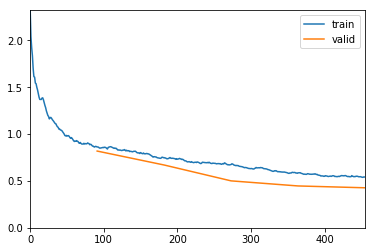

In [17]:
model.fit_one_cycle(5,1e-2)

In [18]:
model.unfreeze()
# model.lr_find()
# model.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.509417,0.425603,0.840164,0.159836,05:42
1,0.506924,0.425863,0.840164,0.159836,05:44
2,0.506881,0.421564,0.845628,0.154372,05:42
3,0.499876,0.422746,0.837432,0.162568,05:43
4,0.497376,0.422008,0.846995,0.153005,05:47
5,0.475791,0.424328,0.837432,0.162568,05:44
6,0.465439,0.418638,0.845628,0.154372,05:44
7,0.477183,0.420074,0.844262,0.155738,05:45
8,0.460818,0.421445,0.841530,0.158470,05:43
9,0.471057,0.421493,0.841530,0.158470,05:34


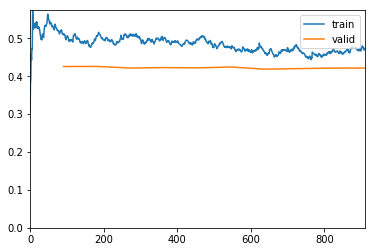

In [19]:
model.fit_one_cycle(10,max_lr = slice(1e-6,1e-4))

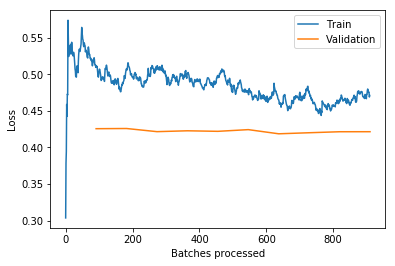

In [20]:
model.recorder.plot_losses()

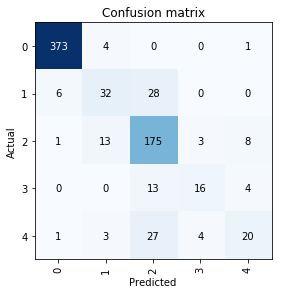

In [21]:
interpreter = ClassificationInterpretation.from_learner(model)
interpreter.plot_confusion_matrix()

In [22]:
preds, _ = model.get_preds(ds_type=DatasetType.Test)

In [23]:
test_df["diagnosis"] = preds.argmax(1)

In [24]:
test_df.to_csv('submission.csv', index=False)